In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.font_manager
import dash

In [2]:
df = pd.read_excel("data/20191116_Misstarget_Abuse_Pattern.xlsx")

In [3]:
df.shape

(13469, 32)

In [4]:
selected_cols = [
    "MonthReport",
    "REF_UID",
    "PROJECT_NAME",
    "PM_NAME",
    "PD_NAME",
    "Forecast_Cash_Flow_Display",
    "Actual_Cash_Flow_Display",
    "Tolerances_Name"
]

In [5]:
df.columns

Index(['DATA_TYPE', 'MonthReport', 'REF_UID', 'PROJECT_NAME', 'PM_ID',
       'PM_NAME', 'PD_ID', 'PD_NAME', 'BUDGET', 'Quarter',
       'Forecast_Cash_Flow', 'Actual_Cash_Flow', 'Forecast_Cash_Flow_Display',
       'Actual_Cash_Flow_Display', 'Variance_Display', 'Variance',
       'Percentage', 'Percentage_Display', 'Color', 'Tolerance_Level',
       'PC_Date', 'ClOSE_DATE', 'Tolerances_Name', 'Forecast_Cash_Flow_Total',
       'Forecast_Cash_Flow_Total_Display', 'Actual_Cash_Flow_Total',
       'Actual_Cash_Flow_Total_Display', 'Variance_Total',
       'Variance_Total_Display', 'Percentage_Average',
       'Percentage_Average_Display', 'TIMESTAMP'],
      dtype='object')

In [6]:
df = df[selected_cols]

In [7]:
df.head()

,MonthReport,REF_UID,PROJECT_NAME,PM_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
0,2017-07,83,Project Feasibility Assessments - Prior to 2015,Michael Scott,Nicole Collin,0.0,5.46,Meet Target
1,2017-08,83,Project Feasibility Assessments - Prior to 2015,Michael Scott,Program Admin,0.0,44.19,Meet Target
2,2017-09,83,Project Feasibility Assessments - Prior to 2015,Michael Scott,Program Admin,0.0,17.02,Meet Target
3,2017-10,83,Project Feasibility Assessments - Prior to 2015,Michael Scott,Program Admin,0.0,3.59,Meet Target
4,2017-11,83,Project Feasibility Assessments - Prior to 2015,Michael Scott,Program Admin,0.0,4.13,Meet Target


##### Remove Project with `Tolerances_Name` == `Not Applicable`

In [8]:
df = df[df['Tolerances_Name']!='Not Applicable']

##### Remove Project with PD_NAME=Program Admin

In [9]:
df = df[df['PD_NAME']!='Program Admin']

##### Remove Project with Forecast=0 and Actual=0

In [10]:
df = df[~((df['Forecast_Cash_Flow_Display']==0) & (df['Actual_Cash_Flow_Display']==0))]

##### Remove PM in List

In [11]:
PM_remove = [
    'Carol Loh',
    'Loi Tran',
    'Axel Keert',
    'Program Admin',
    'Michael Scott',
    'Program Close',
    'Bradley Williamson',
    'Richard Feltscheer',
    'Tish Booth',
    'Stephen Lindsay',
    'David Baker',
    'Nethmi Dassanayake'
]
df = df[~df['PM_NAME'].isin(PM_remove)]

In [12]:
df[df['Forecast_Cash_Flow_Display']==0].shape

(730, 8)

##### Remove SSAF Project with < 50K

In [13]:
name = 'Angus McGarvie'
# name = 'Jonathon Egan '
# df[df['PM_NAME']==name][df['Forecast_Cash_Flow_Display']==0][df['Actual_Cash_Flow_Display']>50].shape[0] /df[df['PM_NAME']==name].shape[0]

In [14]:
df[df['PM_NAME']==name][df['Forecast_Cash_Flow_Display']==0].shape

(124, 8)

In [15]:
df = df[~(df['PROJECT_NAME'].str.contains('SSAF') & (df['Actual_Cash_Flow_Display']<50) & (df['Forecast_Cash_Flow_Display']==0))]

##### Remove Project ID = 1162

In [16]:
df = df[df['REF_UID']!=1162]

In [17]:
year_list = ['2016', '2017', '2018', '2019']
for year in year_list:
    print(f"{year}: {df[(df['MonthReport'].str.contains(year))].shape[0]}")

2016: 1671
2017: 1687
2018: 1457
2019: 1144


In [18]:
# Exclude 2016 and 2017
df = \
df[(df['MonthReport'].str.contains('2018')) \
   | (df['MonthReport'].str.contains('2019')) 
  ]

In [19]:
print(f"Total Project in: {df.shape[0]}")

Total Project in: 2601


In [20]:
df_analytics = df.copy()

In [21]:
# df_analytics['Forecast_Variation'] = df_analytics['Forecast_Cash_Flow_Display'] - df_analytics['Actual_Cash_Flow_Display']
# df_analytics['Forecast_Variation_Perc'] = df_analytics['Forecast_Variation'] / (df_analytics['Actual_Cash_Flow_Display'] + 0.001)
# df_analytics['Forecast_Variation_Perc'] = df_analytics['Forecast_Variation_Perc'].astype('float')
df_analytics['Forecast_Cash_Flow_Display'] = df_analytics['Forecast_Cash_Flow_Display'].astype('float')
df_analytics['Actual_Cash_Flow_Display'] =  df_analytics['Actual_Cash_Flow_Display'].astype('float')

#### Save PM Zero Forecast Project

In [22]:
for name in df_analytics['PM_NAME'].drop_duplicates():
    df_analytics_tmp =  \
      df_analytics[df_analytics['PM_NAME']==name][df_analytics['Forecast_Cash_Flow_Display']==0]
    df_analytics_tmp.to_csv(f'./output/pm_data/{name}_zero_fcst.csv')

In [23]:
df_analytics.head(10)

,MonthReport,REF_UID,PROJECT_NAME,PM_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
36,2018-01,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,6.29,6.29,Meet Target
37,2018-02,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,43.80,38.18,Critical
38,2018-03,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,15.55,32.21,Meet Target
39,2018-04,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,0.00,7.95,Meet Target
40,2018-05,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,23.56,6.09,Critical
41,2018-06,291,Biomedical Learning and Teaching Building,Cristina De Pellegrin,Richard Feltscheer,8651.09,8480.29,Meet Target
42,2018-07,291,Biomedical Learning and Teaching Building,Cristina De Pellegrin,Richard Feltscheer,8527.16,7833.03,Critical
43,2018-08,291,Biomedical Learning and Teaching Building,Cristina De Pellegrin,Richard Feltscheer,7548.07,7273.06,Near Target
44,2018-09,291,Biomedical Learning and Teaching Building,Cristina De Pellegrin,Richard Feltscheer,7806.35,7381.22,Critical
45,2018-10,291,Biomedical Learning and Teaching Building,Cristina De Pellegrin,Richard Feltscheer,6018.61,7378.46,Meet Target


In [24]:
# PM_name = 'Angus McGarvie'
# PM_name = 'Dean Ristevski'
PM_name = 'Jeremy Chong'
df_person = df_analytics[df_analytics['PM_NAME']==PM_name]
# df_person[df_person['Forecast_Cash_Flow_Display']==0]
df_person.head(3)

,MonthReport,REF_UID,PROJECT_NAME,PM_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
1325,2019-04,792,CL 1 Doug Ellis Main Pool Remedial Work,Jeremy Chong,Axel Keert,0.00,1.61,Meet Target
1327,2019-06,792,CL 1 Doug Ellis Main Pool Remedial Work,Jeremy Chong,Axel Keert,1.30,0.00,Critical
1641,2018-02,842,Monash Sport Reception and Cafe,Jeremy Chong,Axel Keert,12.42,12.42,Meet Target


In [25]:
underspend = df_person[(df_person['Forecast_Cash_Flow_Display'] - df_person['Actual_Cash_Flow_Display']) * 2 \
                    /(df_person['Actual_Cash_Flow_Display'] + df_person['Forecast_Cash_Flow_Display'])>0.05].shape[0]
print(f"underspend:{underspend}")
overderspend = df_person[(df_person['Actual_Cash_Flow_Display'] - df_person['Forecast_Cash_Flow_Display']) * 2 \
                    /(df_person['Actual_Cash_Flow_Display'] + df_person['Forecast_Cash_Flow_Display'])>0.05].shape[0]
print(f"overderspend:{overderspend}")

underspend:45
overderspend:48


In [26]:
# df_person[(df_person['Forecast_Cash_Flow_Display'] - df_person['Actual_Cash_Flow_Display']) * 2 \
#                     /(df_person['Actual_Cash_Flow_Display'] + df_person['Forecast_Cash_Flow_Display'])>0.05]

In [27]:
df_0 = df[df['Forecast_Cash_Flow_Display']==0]
df_0.groupby(['PM_NAME']).count().sort_values('MonthReport',ascending=False)

,MonthReport,REF_UID,PROJECT_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
PM_NAME,,,,,,,
Angus McGarvie,89,89,89,89,89,89,89
Jeremy Chong,27,27,27,27,27,27,27
Aarron Cowen,21,21,21,21,21,21,21
Nick Ditterich,19,19,19,19,19,19,19
Vivienne Elder-Smith,16,16,16,16,16,16,16
Alexis Kouts,16,16,16,16,16,16,16
Jodie Katada,15,15,15,15,15,15,15
Hiruni Eriyagama,13,13,13,13,13,13,13
Arash Emami,13,13,13,13,13,13,13


In [28]:
PM_list = list(set(df_analytics['PM_NAME']))

In [29]:
pm_perf = dict()

for name in PM_list:
#     if name != 'Angus McGarvie':
#     if name != 'Aarron Cowen':
#     if name != 'Matthew Bartlett':
#         continue

    df_tmp = df_analytics[df_analytics['PM_NAME']==name]
    mse = mean_squared_error(df_tmp['Actual_Cash_Flow_Display'], df_tmp['Forecast_Cash_Flow_Display']) / sum(df_tmp['Actual_Cash_Flow_Display'])
    
    # Metric: Project Delivered
    project_num = df_tmp.shape[0]
    
    # Metric: Total Project Value Delivered
    project_value = df_tmp['Actual_Cash_Flow_Display'].sum()
    project_value_inv = 1.0 / np.sqrt(project_value)
    
    # Metric: Number of Time that Put Forecast as Zero
    zero_fcst = df_tmp[df_tmp['Forecast_Cash_Flow_Display']==0].shape[0]
    
    # Metric KS Distribution
#     ks_distrb = ks_2samp(df_tmp['Forecast_Cash_Flow_Display'], df_tmp['Actual_Cash_Flow_Display'])
    
    # Metric: Total Number of Time that Missing Target
    underspend = df_tmp[(df_tmp['Forecast_Cash_Flow_Display'] - df_tmp['Actual_Cash_Flow_Display']) * 2 \
                        /(df_tmp['Actual_Cash_Flow_Display'] + df_tmp['Forecast_Cash_Flow_Display'])>0.05].shape[0]
                        
    overderspend = df_tmp[(df_tmp['Actual_Cash_Flow_Display'] - df_tmp['Forecast_Cash_Flow_Display']) * 2 \
                        /(df_tmp['Actual_Cash_Flow_Display'] + df_tmp['Forecast_Cash_Flow_Display'])>0.05].shape[0]
    
    underspend_project_num = underspend
    overspend_project_num = overderspend
   
    # Metric: Overspend/Underspend $
    df_tmp['spend_diff'] = df_tmp['Forecast_Cash_Flow_Display'] - df_tmp['Actual_Cash_Flow_Display']
    underspend_value = abs(sum(df_tmp[df_tmp['spend_diff']>0]['spend_diff']))                       
    overderspend_value = abs(sum(df_tmp[df_tmp['spend_diff']<0]['spend_diff']))  


    miss_target_project_num = underspend + overderspend

    # Metric: Percentage of Miss-target Project
    miss_target_project_ratio = miss_target_project_num / project_num

    
    # Metric: MAPE
    df_tmp.loc[:,'miss_taget_value_monthly_mape'] = abs(df_tmp['Forecast_Cash_Flow_Display'] - df_tmp['Actual_Cash_Flow_Display']) * 2 /\
                                           (df_tmp['Forecast_Cash_Flow_Display'] + df_tmp['Actual_Cash_Flow_Display'])
    
    miss_taget_value_monthly_mape = df_tmp['miss_taget_value_monthly_mape'].mean()
    
    # Metric: Total Missing Target $ Value (Can Cancel Off)
    miss_target_value = sum(df_tmp['Forecast_Cash_Flow_Display']) - sum(df_tmp['Actual_Cash_Flow_Display'])
    
    # Metric: Total Missing Target $ Value Percentage (Can Cancel Off)    
    miss_target_value_perc_error = abs(sum(df_tmp['Forecast_Cash_Flow_Display']) - sum(df_tmp['Actual_Cash_Flow_Display'])) * 2 / \
                                   (sum(df_tmp['Forecast_Cash_Flow_Display']) + sum(df_tmp['Actual_Cash_Flow_Display']))

    # Metric: Total Logged Missing Target Absolute $ Value (Can't Cancel Off)    
    miss_target_value_log_error = np.log(sum(abs((df_tmp['Forecast_Cash_Flow_Display']) - (df_tmp['Actual_Cash_Flow_Display']))))
    
    pm_perf[name] = [
        project_num,
        project_value,
        project_value_inv,
        zero_fcst,
#         ks_distrb,
        miss_taget_value_monthly_mape,
        miss_target_project_num,
        underspend_project_num,
        overspend_project_num,
        underspend_value,
        overderspend_value,
        miss_target_project_ratio,
        miss_target_value,
        miss_target_value_perc_error,
        miss_target_value_log_error
    ]

In [30]:
df_pm_perf = pd.DataFrame.from_dict(pm_perf, orient='index',
                                 columns=['project_num',
                                          'project_value',
                                          'project_value_inv',
                                          'zero_fcst',
#                                           'ks_distrb',
                                          'miss_taget_value_monthly_mape',
                                          'miss_target_project_num',
                                          'underspend_project_num',
                                          'overspend_project_num',
                                          'underspend_value',
                                          'overderspend_value',
                                          'miss_target_project_ratio',
                                          'miss_target_value',
                                          'miss_target_value_perc_error',
                                          'miss_target_value_log_error'
                                         ])

In [31]:
# Only track PMs who have delivered >10 project and total project value > $50K
df_pm_perf = df_pm_perf[(df_pm_perf['project_num']>=10) | (df_pm_perf['project_value']>=50)]

In [32]:
df_pm_perf.sort_values('miss_taget_value_monthly_mape').tail(3)

,project_num,project_value,project_value_inv,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_num,underspend_project_num,overspend_project_num,underspend_value,overderspend_value,miss_target_project_ratio,miss_target_value,miss_target_value_perc_error,miss_target_value_log_error
Jodie Katada,35,891.81,0.033486,15,1.581520,33,16,17,347.98,644.99,0.942857,-297.01,0.399580,6.900700
Angus McGarvie,152,8884.76,0.010609,89,1.602316,144,32,112,292.38,5855.76,0.947368,-5563.38,0.911571,8.723905
Jarrod Filosa,16,40.94,0.156288,0,1.787894,16,16,0,362.09,0.00,1.000000,362.09,1.631146,5.891893


#### Good PM

In [33]:
df_pm_perf[(df_pm_perf.index=='Dean Ristevski') \
           | (df_pm_perf.index=='Jeremy Chong') \
           | (df_pm_perf.index=='Jonathon Egan ')\
           | (df_pm_perf.index=='Arash Emami')\
           | (df_pm_perf.index=='James Creech')\
           | (df_pm_perf.index=='Ryan Spittel')
          ]

,project_num,project_value,project_value_inv,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_num,underspend_project_num,overspend_project_num,underspend_value,overderspend_value,miss_target_project_ratio,miss_target_value,miss_target_value_perc_error,miss_target_value_log_error
Jonathon Egan,319,9319.18,0.010359,12,1.268858,267,210,57,1716.55,1886.06,0.836991,-169.51,0.018356,8.189414
Ryan Spittel,63,40681.31,0.004958,4,0.645170,32,19,13,3911.24,1761.48,0.507937,2149.76,0.051484,8.643424
Dean Ristevski,65,13356.54,0.008653,10,0.961929,52,19,33,927.79,4097.60,0.800000,-3169.81,0.269275,8.522258
Jeremy Chong,120,5954.87,0.012959,27,1.066846,93,45,48,865.61,560.61,0.775000,305.00,0.049940,7.262783
James Creech,77,6416.33,0.012484,5,0.949461,57,37,20,1395.52,566.23,0.740260,829.29,0.121401,7.581592
Arash Emami,128,19764.95,0.007113,13,0.716473,84,29,55,3072.55,4891.34,0.656250,-1818.79,0.096459,8.982673


#### Bad PM

In [34]:
df_pm_perf[(df_pm_perf.index=='Angus McGarvie') \
           | (df_pm_perf.index=='Aarron Cowen') \
           | (df_pm_perf.index=='Eric Sun') \
           | (df_pm_perf.index=='Bijins Joy')           
          ]

,project_num,project_value,project_value_inv,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_num,underspend_project_num,overspend_project_num,underspend_value,overderspend_value,miss_target_project_ratio,miss_target_value,miss_target_value_perc_error,miss_target_value_log_error
Angus McGarvie,152,8884.76,0.010609,89,1.602316,144,32,112,292.38,5855.76,0.947368,-5563.38,0.911571,8.723905
Bijins Joy,46,1020.19,0.031308,8,0.757145,32,9,23,38.02,255.90,0.695652,-217.88,0.239100,5.683308
Aarron Cowen,140,8395.48,0.010914,21,1.137502,132,70,62,2531.54,1756.24,0.942857,775.30,0.088271,8.363524
Eric Sun,30,9034.31,0.010521,6,0.972625,26,10,16,2318.91,3585.22,0.866667,-1266.31,0.150730,8.683407


In [35]:
df_pm_perf.sort_values('miss_target_value_perc_error')

,project_num,project_value,project_value_inv,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_num,underspend_project_num,overspend_project_num,underspend_value,overderspend_value,miss_target_project_ratio,miss_target_value,miss_target_value_perc_error,miss_target_value_log_error
Mark Barrett,4,351.26,0.053356,0,0.615225,4,2,2,82.84,80.08,1.000000,2.76,0.007827,5.093259
Jonathon Egan,319,9319.18,0.010359,12,1.268858,267,210,57,1716.55,1886.06,0.836991,-169.51,0.018356,8.189414
Ryan Martin,43,2450.63,0.020200,10,0.935929,31,16,15,365.92,279.50,0.720930,86.42,0.034653,6.469901
Hiruni Eriyagama,97,6706.35,0.012211,13,1.070321,83,43,40,1858.09,2094.21,0.855670,-236.12,0.035839,8.282053
Cristina De Pellegrin,41,101884.34,0.003133,3,0.803350,35,23,12,13423.61,9340.21,0.853659,4083.40,0.039291,10.032928
Alexis Kouts,79,105390.88,0.003080,16,0.971761,62,36,26,5977.42,1631.25,0.784810,4346.17,0.040405,8.937044
Jeremy Chong,120,5954.87,0.012959,27,1.066846,93,45,48,865.61,560.61,0.775000,305.00,0.049940,7.262783
Ryan Spittel,63,40681.31,0.004958,4,0.645170,32,19,13,3911.24,1761.48,0.507937,2149.76,0.051484,8.643424
Jacqueline Talevska,23,13763.16,0.008524,1,0.812424,16,12,4,1420.97,601.66,0.695652,819.31,0.057809,7.612154
Jack Izowski,78,6845.71,0.012086,12,1.156784,70,34,36,2047.72,2454.33,0.897436,-406.61,0.061214,8.412288


In [36]:
col_list = [
    'zero_fcst',
    'project_value_inv',
    'miss_taget_value_monthly_mape',  
    'miss_target_project_ratio',
#     'miss_target_value',
    'miss_target_value_perc_error',
#     'miss_target_value_log_error'
]

df_pm_perf_select = df_pm_perf[col_list].dropna()

In [37]:
df_pm_perf_select.head(3)

,zero_fcst,project_value_inv,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value_perc_error
Jarrod Filosa,0,0.156288,1.787894,1.000000,1.631146
Daniel Bartel,0,0.032168,0.797948,0.785714,0.645298
Jack Izowski,12,0.012086,1.156784,0.897436,0.061214


In [38]:
for col in col_list:
    df_pm_perf_select[col] = df_pm_perf_select[col] / df_pm_perf_select[col].max()

In [39]:
data = df_pm_perf_select[col_list].as_matrix()

In [40]:
top_n_outlier = 20
num_PM = len(PM_list)
outliers_fraction = top_n_outlier * 1.0 / num_PM

In [41]:
select_metrics= [
    'miss_taget_value_monthly_mape',
    'project_value_inv',
    'project_value_inv',
    'miss_target_project_ratio',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
#     'miss_target_value',
#     'miss_target_value_log_error'
]

In [42]:
df_pm_perf_select[select_metrics]

,miss_taget_value_monthly_mape,project_value_inv,project_value_inv,miss_target_project_ratio,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error
Jarrod Filosa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Daniel Bartel,0.446306,0.205828,0.205828,0.785714,0.395610,0.395610,0.395610,0.395610,0.395610,0.395610,0.395610,0.395610
Jack Izowski,0.647009,0.077333,0.077333,0.897436,0.037528,0.037528,0.037528,0.037528,0.037528,0.037528,0.037528,0.037528
Mark Bray,0.548089,0.112216,0.112216,0.710526,0.328712,0.328712,0.328712,0.328712,0.328712,0.328712,0.328712,0.328712
Jonathon Egan,0.709694,0.066280,0.066280,0.836991,0.011254,0.011254,0.011254,0.011254,0.011254,0.011254,0.011254,0.011254
David Tabatabaian,0.336859,0.897193,0.897193,0.600000,0.101901,0.101901,0.101901,0.101901,0.101901,0.101901,0.101901,0.101901
Anna Devlin,0.721958,0.192490,0.192490,1.000000,0.330707,0.330707,0.330707,0.330707,0.330707,0.330707,0.330707,0.330707
Ryan Spittel,0.360854,0.031723,0.031723,0.507937,0.031563,0.031563,0.031563,0.031563,0.031563,0.031563,0.031563,0.031563
Rebal Fakhreddine,0.558084,0.297476,0.297476,0.954545,0.161279,0.161279,0.161279,0.161279,0.161279,0.161279,0.161279,0.161279
Dean Ristevski,0.538023,0.055364,0.055364,0.800000,0.165083,0.165083,0.165083,0.165083,0.165083,0.165083,0.165083,0.165083


In [43]:
df_pm_perf_select['pm_performance_score[abs]'] = 1 - df_pm_perf_select.apply(lambda x: np.linalg.norm(x[select_metrics]), axis=1)/np.sqrt(len(select_metrics))

In [44]:
print(f"Median Score: {df_pm_perf_select['pm_performance_score[abs]'].median():.02f}")

Median Score: 0.68


In [45]:
df_pm_perf_select.sort_values('pm_performance_score[abs]', ascending=False).tail(20)

,zero_fcst,project_value_inv,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value_perc_error,pm_performance_score[abs]
Mark Soderlund,0.101124,0.067730,0.527987,0.873874,0.166620,0.674206
Ron Too,0.123596,0.070130,0.615386,0.862069,0.142905,0.671484
Aarron Cowen,0.235955,0.069831,0.636225,0.942857,0.054116,0.667466
Mark Barrett,0.000000,0.341397,0.344106,1.000000,0.004798,0.664379
Chris Webster,0.000000,0.118845,0.430798,1.000000,0.176687,0.650765
Rebal Fakhreddine,0.000000,0.297476,0.558084,0.954545,0.161279,0.633975
David Chauhan,0.033708,0.083013,0.621814,0.902778,0.230479,0.630269
Robert Dickson,0.033708,0.170865,0.769406,1.000000,0.068657,0.624935
Mark Bray,0.123596,0.112216,0.548089,0.710526,0.328712,0.624185
Gavin Zhang,0.022472,0.272239,0.543374,0.785714,0.287929,0.620960


In [46]:
df_pm_perf_select[(df_pm_perf_select.index=='Dean Ristevski') \
           | (df_pm_perf_select.index=='Jeremy Chong') \
           | (df_pm_perf_select.index=='Jonathon Egan ')\
           | (df_pm_perf_select.index=='Arash Emami')\
           | (df_pm_perf_select.index=='James Creech')\
           | (df_pm_perf_select.index=='Ryan Spittel')
          ]

,zero_fcst,project_value_inv,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value_perc_error,pm_performance_score[abs]
Jonathon Egan,0.134831,0.066280,0.709694,0.836991,0.011254,0.681931
Ryan Spittel,0.044944,0.031723,0.360854,0.507937,0.031563,0.817838
Dean Ristevski,0.112360,0.055364,0.538023,0.800000,0.165083,0.689944
Jeremy Chong,0.303371,0.082916,0.596705,0.775000,0.030616,0.714528
James Creech,0.056180,0.079879,0.531050,0.740260,0.074427,0.728112
Arash Emami,0.146067,0.045512,0.400735,0.656250,0.059136,0.772080


In [47]:
df_pm_perf_select[(df_pm_perf_select.index=='Angus McGarvie') \
           | (df_pm_perf_select.index=='Aarron Cowen') \
           | (df_pm_perf_select.index=='Eric Sun') \
           | (df_pm_perf_select.index=='Bijins Joy')           
          ]

,zero_fcst,project_value_inv,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value_perc_error,pm_performance_score[abs]
Angus McGarvie,1.000000,0.067881,0.896203,0.947368,0.558853,0.407798
Bijins Joy,0.089888,0.200324,0.423484,0.695652,0.146584,0.723802
Aarron Cowen,0.235955,0.069831,0.636225,0.942857,0.054116,0.667466
Eric Sun,0.067416,0.067317,0.544006,0.866667,0.092408,0.693891


In [48]:
classifiers = {
#         'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
#         'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=42),
#         'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=42),
#         'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
#         'Isolation Forest': IForest(contamination=outliers_fraction,random_state=42),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
#         'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

In [49]:
col_list = ['pm_performance_score[abs]', 'zero_fcst']

for col in col_list:
    df_pm_perf_select[col] = df_pm_perf_select[col] / df_pm_perf_select[col].max()

In [50]:
top_n_outlier = 8

X_train = df_pm_perf_select[col_list].as_matrix()

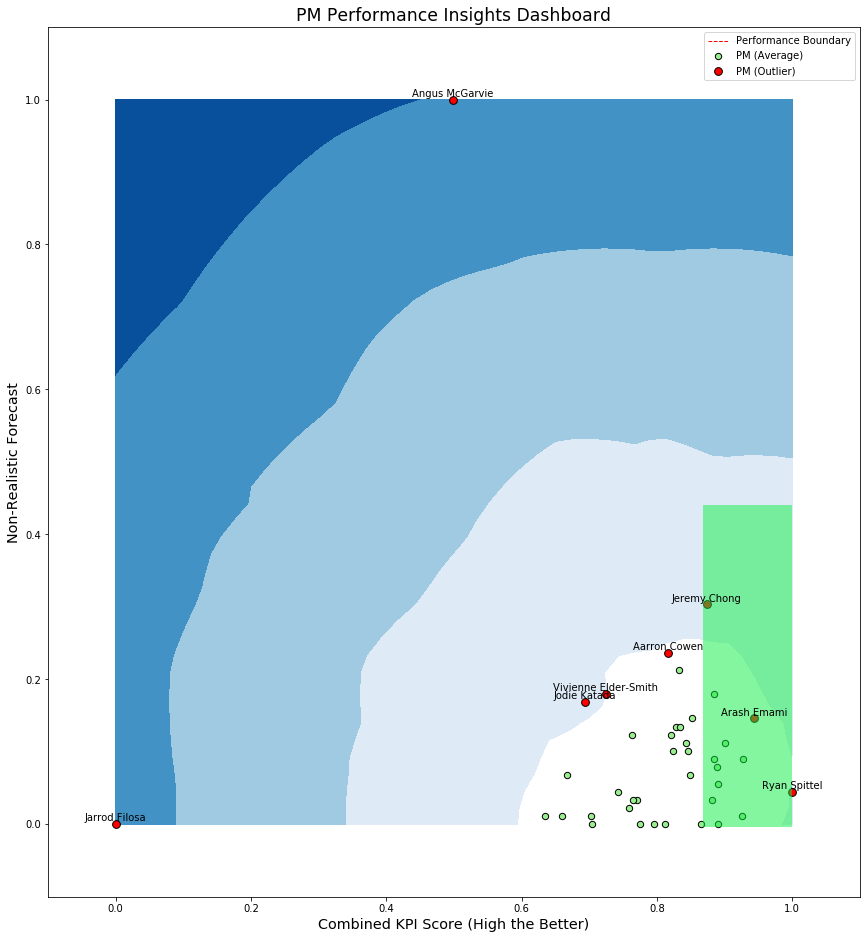

In [51]:
#set the figure size

fig = plt.figure(figsize=(32, 16))

xx , yy = np.meshgrid(np.linspace(0, 1, num_PM), np.linspace(0, 1, num_PM))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)
    y_pred_proba = clf.predict_proba(X_train)
    threshold = np.percentile(y_pred_proba[:,0], 20)
    y_pred = np.where(y_pred_proba[:,0]>threshold, 0, 1)
    
    df_pm_perf_select['outlier'] = y_pred
    
    perf_median = np.median(df_pm_perf_select[df_pm_perf_select['outlier']!=1]['pm_performance_score[abs]'].values)
    perf_70pt = np.percentile(df_pm_perf_select['pm_performance_score[abs]'],70)
    high_perf_threshold = perf_70pt
    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred, top_n_outlier)

#     # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold+0.02, 5),cmap=plt.cm.Blues_r)

#     # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold+0.12],linewidths=1, colors='red')

#     # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
#     subplot.contourf(xx, yy, Z, levels=[threshold+0.02, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
#     b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 

#     df_pm_perf_select.loc[
#         df_pm_perf_select['outlier']==0, 'high_performer'
#     ] = 0
#     df_pm_perf_select.loc[
#         df_pm_perf_select['outlier']==1, 'high_performer'
#     ] = -1
#     df_pm_perf_select.loc[
#         (df_pm_perf_select['pm_performance_score[abs]']>high_perf_threshold)\
#         & (df_pm_perf_select['outlier']==1)\
#         & (df_pm_perf_select['zero_fcst']<0.5), 'high_performer'
#     ] = 1

#     df_pm_perf_select_outperformer = df_pm_perf_select[df_pm_perf_select['high_performer']==1]
#     df_pm_perf_select_underperformer = df_pm_perf_select[df_pm_perf_select['high_performer']==-1]
#     df_pm_perf_select_average = df_pm_perf_select[df_pm_perf_select['high_performer']==0]

    df_pm_perf_select_ok = df_pm_perf_select[df_pm_perf_select['outlier']==0]
    df_pm_perf_select_under = df_pm_perf_select[df_pm_perf_select['outlier']==1]

    inlier = subplot.scatter(df_pm_perf_select_ok[col_list[0]], df_pm_perf_select_ok[col_list[1]], c='#99EE90',s=40, edgecolor='k') 
    outlier = subplot.scatter(df_pm_perf_select_under[col_list[0]], df_pm_perf_select_under[col_list[1]], c='red',s=60, edgecolor='k')
#     average = subplot.scatter(df_pm_perf_select_average[col_list[0]], df_pm_perf_select_average[col_list[1]], c='#99EE90',s=40, edgecolor='k') 
#     outperformer = subplot.scatter(df_pm_perf_select_outperformer[col_list[0]], df_pm_perf_select_outperformer[col_list[1]], c='blue',s=60, edgecolor='k')
#     underperformer = subplot.scatter(df_pm_perf_select_underperformer[col_list[0]], df_pm_perf_select_underperformer[col_list[1]], c='red',s=60, edgecolor='k')

    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], inlier, outlier],
        ['Performance Boundary', 'PM (Average)', 'PM (Outlier)'],
#         [average, outperformer, underperformer],
#         ['PM (Average)', 'PM (Outperformance)', 'PM (Underperformance)'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='higher right')

    subplot.set_title("PM Performance Insights Dashboard", fontsize='xx-large')
    x_axis_max = df_pm_perf_select[col_list[0]].max()*1.1
    x_axis_min = min(df_pm_perf_select[col_list[0]].min()*1.1, -0.1)
    y_axis_max = df_pm_perf_select[col_list[1]].max()*1.1
    y_axis_min = min(df_pm_perf_select[col_list[1]].min()*1.1, -0.1)
    plt.axvspan(high_perf_threshold, 1, ymin = 0.08, ymax = 0.45, facecolor='#0DEF42', alpha=0.5)
    
    subplot.set_xlim((x_axis_min, x_axis_max))
    subplot.set_ylim((y_axis_min, y_axis_max))
    subplot.set_xlabel("Combined KPI Score (High the Better)", fontsize='x-large')
    subplot.set_ylabel("Non-Realistic Forecast", fontsize='x-large')
    for index, row in df_pm_perf_select.iterrows():

        label = index
        x = row[col_list[0]]
        y = row[col_list[1]]
        
        if row['outlier']==0:
            continue
            
#         if label != 'Angus McGarvie':
#             continue
            
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,3), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.savefig('./output/pm_performance_dashboard.pdf')
    plt.show()

In [52]:
df_pm_perf_select[df_pm_perf_select['outlier']==1]

,zero_fcst,project_value_inv,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value_perc_error,pm_performance_score[abs],outlier
Jarrod Filosa,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
Ryan Spittel,0.044944,0.031723,0.360854,0.507937,0.031563,1.000000,1
Angus McGarvie,1.000000,0.067881,0.896203,0.947368,0.558853,0.498630,1
Jeremy Chong,0.303371,0.082916,0.596705,0.775000,0.030616,0.873680,1
Jodie Katada,0.168539,0.214258,0.884571,0.942857,0.244969,0.694061,1
Vivienne Elder-Smith,0.179775,0.094499,0.628716,0.865772,0.321771,0.724681,1
Aarron Cowen,0.235955,0.069831,0.636225,0.942857,0.054116,0.816136,1
Arash Emami,0.146067,0.045512,0.400735,0.656250,0.059136,0.944050,1


In [53]:
df_pm_perf_select[['zero_fcst', 'pm_performance_score[abs]', 'outlier']].reset_index().rename(columns={'index':'pm'}).to_csv('./output/pm_perf.csv', index=False)

In [54]:
pd.read_csv('output/pm_perf.csv').head(3)

,pm,zero_fcst,pm_performance_score[abs],outlier
0,Jarrod Filosa,0.000000,0.000000,1
1,Daniel Bartel,0.000000,0.704776,0
2,Jack Izowski,0.134831,0.828536,0


In [55]:
# df_angus['Forecast_Cash_Flow_Display'].plot(figsize=(24,16))
# df_angus['Actual_Cash_Flow_Display'].plot(figsize=(24,16))

In [56]:
# agg_cond = [
#     'PM_NAME',
# ]
# target = ['Forecast_Variation_Perc']
# selected_cols = agg_cond + target
# agg_ops = [
#     'mean'
# ]
# agg_target = target[0] + '_' + agg_ops[0]
# df_agg = df_analytics[selected_cols].groupby(agg_cond).agg(agg_ops)

# df_agg.columns = ['_'.join(col).strip(' ') for col in df_agg.columns.values]
# df_agg = df_agg.reset_index()

# df_agg.sort_values(agg_target, ascending=False)

In [57]:
import plotly.offline as pyo
import plotly.graph_objs as go

In [58]:
np.random.seed(42)
random_x = np.random.randint(1,101,100)
random_y = np.random.randint(1,101,100)

df = pd.read_csv('data/pm_perf.csv')

data = [go.Scatter(x=[high_perf_threshold, high_perf_threshold, 1, 1], y=[0, 0.5, 0.5, 0],
                    fill='toself', fillcolor='rgba(135, 206, 250, 0.2)',
                    name="High Performance Area",
                    hoverinfo='text+x+y')]

data = \
data + ([go.Scatter(x=df[df['outlier']==0]['pm_performance_score[abs]'],
                   y=df[df['outlier']==0]['zero_fcst'],
                   text = df[df['outlier']==0]['pm'],
                   mode='markers',
                   name = "PM (Average)",
                   marker=dict(
                     size=8,
                     color='rgb(51,204,153)',
                     symbol='circle',
                     line={'width':2}
                   ))])

data = \
data + ([go.Scatter(x=df[df['outlier']==1]['pm_performance_score[abs]'],
                   y=df[df['outlier']==1]['zero_fcst'],
                   text = df[df['outlier']==1]['pm'],
                   mode='markers',
                   name = "PM (Outlier)",
                   marker=dict(
                     size=8,
                     color='red',
                     symbol='circle',
                     line={'width':2}
                   ))])

layout = go.Layout(title='PM Performance Insights Dashboard',
                   xaxis=dict(title='Combined KPI Score (High the Better)'),
                   yaxis=dict(title='Non-Realistic Forecast'),
                   hovermode='closest')

fig = go.Figure(data=data,layout=layout)

pyo.plot(fig, filename='output/pm_perf_dashboard_interactive.html')

'output/pm_perf_dashboard_interactive.html'

In [59]:
df_pm_perf_vis = df_pm_perf[['underspend_value', 'overderspend_value', 'miss_target_project_ratio']].merge(df_pm_perf_select['outlier'], how='inner', left_index=True, right_index =True)

In [60]:
df_pm_perf_vis['underspend_value'] = df_pm_perf_vis['underspend_value'].astype('int')
df_pm_perf_vis['overderspend_value'] = df_pm_perf_vis['overderspend_value'].astype('int')
df_pm_perf_vis['miss_target_project_ratio'] = df_pm_perf_vis['miss_target_project_ratio']*100
df_pm_perf_vis['miss_target_project_ratio'] = df_pm_perf_vis['miss_target_project_ratio'].astype('int')

In [61]:
df_pm_perf_vis = df_pm_perf_vis.reset_index().rename(columns={'index':'pm'})

In [62]:
# import plotly.express as px
# iris = px.data.iris()
# fig = px.scatter_3d(df_pm_perf_vis, 
#                     x='underspend_value', 
#                     y='overderspend_value', 
#                     z='miss_target_project_ratio',
#                     color='outlier'
#                    )
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# pyo.plot(fig, filename='pm_spending_dashboard_interactive.html')

In [63]:
data=[go.Scatter3d(
    x=df_pm_perf_vis[df_pm_perf_vis['outlier']==0]['underspend_value'],
    y=df_pm_perf_vis[df_pm_perf_vis['outlier']==0]['overderspend_value'],
    z=df_pm_perf_vis[df_pm_perf_vis['outlier']==0]['miss_target_project_ratio'],
    name = "PM (Average)",
    mode='markers',
    text=df_pm_perf_vis[df_pm_perf_vis['outlier']==0]['pm'],
    marker=dict(
        size=5,
#         color=df_pm_perf_vis['outlier'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)]

data = \
data + ([go.Scatter3d(
    x=df_pm_perf_vis[df_pm_perf_vis['outlier']==1]['underspend_value'],
    y=df_pm_perf_vis[df_pm_perf_vis['outlier']==1]['overderspend_value'],
    z=df_pm_perf_vis[df_pm_perf_vis['outlier']==1]['miss_target_project_ratio'],
    mode='markers',
    name = "PM (Outlier)",
    text=df_pm_perf_vis[df_pm_perf_vis['outlier']==1]['pm'],
    marker=dict(
        size=8,
#         color=df_pm_perf_vis['outlier'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

layout = go.Layout(title='PM Project Spending Dashboard',
                   scene = dict(
                    xaxis_title='X: Underspending Total Value (K$)',
                    yaxis_title='Y: Overspeningd Total Value (K$)',
                    zaxis_title='Z: Ratio of Miss-Target Projects (%)'),
                   width=1400,
#                    xaxis=dict(title='Combined KPI Score (High the Better)'),
#                    yaxis=dict(title='Non-Realistic Forecast'),
#                    zaxis=dict(title='Non-Realistic Forecast'),
                   hovermode='closest')

fig = go.Figure(data=data,layout=layout)
pyo.plot(fig, filename='output/pm_spending_dashboard_interactive.html')

'output/pm_spending_dashboard_interactive.html'